# PyTorch CIFAR-10 training

- Local Instance
- Without SPOT Instance
- With SPOT Instance

This notebook shows how to use the SageMaker Python SDK to run your code in a local container before deploying to SageMaker's managed training or hosting environments. This can speed up iterative testing and debugging while using the same familiar Python SDK interface. Just change your estimator's instance_type to local 

The SageMaker Python SDK helps you deploy your models for training and hosting in optimized, productions ready containers in SageMaker. The SageMaker Python SDK is easy to use, modular, extensible and compatible with TensorFlow, MXNet, PyTorch. This tutorial focuses on how to create a convolutional neural network model to train the CIFAR-10 dataset using PyTorch in local mode.



## SETUP

In [ ]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-cnn-cifar10"

role = sagemaker.get_execution_role()

In [7]:
import uuid
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoint-{}'.format(bucket,
                                                    checkpoint_suffix)
print(f"Checkpoint Path {checkpoint_s3_path}")

Checkpoint Path s3://sagemaker-ap-southeast-1-964564632268/checkpoint-42d7e3f4


In [2]:
import os
import subprocess

instance_type = "local"

try:
    if subprocess.call("nvidia-smi") == 0:
        ## Set type to GPU if one is present
        instance_type = "local_gpu"
except:
    pass

print("Instance type = " + instance_type)

Instance type = local


## DATA

- Download the CIFAR-10 dataset
- Data Preview


In [8]:
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()


Files already downloaded and verified
Files already downloaded and verified


    truck      deer      ship      bird


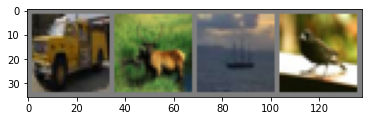

In [9]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(" ".join("%9s" % classes[labels[j]] for j in range(4)))

## Uploading the data to S3


In [10]:
inputs = sagemaker_session.upload_data(
    path="data", bucket=bucket, key_prefix="data/cifar10"
)


In [11]:
!ls data/

cifar-10-batches-py  cifar-10-python.tar.gz  MNIST


## Train on Local Instance


In [6]:
# TRAINING DONE LOCALLY ON THE NOTEBOOK INSTNACE

from sagemaker.pytorch import PyTorch

hyperparameters = {'epochs': 1}

cifar10_estimator = PyTorch(
    entry_point="source/cifar10.py",
    role=role,
    framework_version="1.7.1",
    py_version="py3",
    instance_count=1,
    hyperparameters=hyperparameters,
    instance_type=instance_type,
)

cifar10_estimator.fit(inputs)

Creating 577zqdwskw-algo-1-cser2 ... 
Creating 577zqdwskw-algo-1-cser2 ... done
Attaching to 577zqdwskw-algo-1-cser2
577zqdwskw-algo-1-cser2 | 2022-01-29 07:41:15,747 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
577zqdwskw-algo-1-cser2 | 2022-01-29 07:41:15,749 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
577zqdwskw-algo-1-cser2 | 2022-01-29 07:41:15,762 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
577zqdwskw-algo-1-cser2 | 2022-01-29 07:41:15,784 sagemaker_pytorch_container.training INFO     Invoking user training script.
577zqdwskw-algo-1-cser2 | 2022-01-29 07:41:15,973 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
577zqdwskw-algo-1-cser2 | 2022-01-29 07:41:15,989 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
577zqdwskw-algo-1-cser2 | 2022-01-29 07:41:16,004 sagemaker-training-toolkit 

## Train on ml.m5.4xlarge Instance

- Without SPOT Instance

In [20]:
# WITHOUT SPOT INSTANCES, IT IS GOING TO COST US MORE
from sagemaker.pytorch import PyTorch

hyperparameters = {'epochs': 10}

cifar10_estimator = PyTorch(
    entry_point="source/cifar10.py",
    role=role,
    framework_version="1.7.1",
    py_version="py3",
    instance_count=1,
    hyperparameters=hyperparameters,
    instance_type="ml.m5.4xlarge",
    base_job_name="cifar10-pytorch-session13-TSAI"
)

cifar10_estimator.fit(inputs)

2022-01-29 09:59:27 Starting - Starting the training job...
2022-01-29 09:59:43 Starting - Preparing the instances for trainingProfilerReport-1643450367: InProgress
.........
2022-01-29 10:01:27 Downloading - Downloading input data
2022-01-29 10:01:27 Training - Downloading the training image...
2022-01-29 10:01:52 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-29 10:01:55,228 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-29 10:01:55,230 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-29 10:01:55,240 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-29 10:01:55,250 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-29 10:01:55,632 sagemaker-training-toolkit INFO     No GPUs

### WITHOUT SPOT INSTANCE

- Training seconds: 600
- Billable seconds: 600

## Train on ml.m5.4xlarge SPOT Instance


In [14]:
# WITH SPOT INSTANCES, IT IS GOING TO COST US LESS

use_spot_instances = True
max_run = 600
max_wait = 1200 if use_spot_instances else None

from sagemaker.pytorch import PyTorch

hyperparameters = {'epochs': 5}

cifar10_estimator = PyTorch(
    entry_point="source/cifar10.py",
    role=role,
    framework_version="1.7.1",
    py_version="py3",
    instance_count=1,
    hyperparameters=hyperparameters,
#     instance_type="ml.p3.2xlarge",
    instance_type="ml.m5.4xlarge",
    base_job_name="cifar10-pytorch-spot-session13-TSAI",
    checkpoint_s3_uri=checkpoint_s3_path,
    debugger_hook_config=False,
    use_spot_instances=use_spot_instances,
    max_run=max_run,
    max_wait=max_wait
)

cifar10_estimator.fit(inputs)

2022-01-29 09:35:33 Starting - Starting the training job...
2022-01-29 09:35:58 Starting - Launching requested ML instancesProfilerReport-1643448932: InProgress
...
2022-01-29 09:36:29 Starting - Preparing the instances for training............
2022-01-29 09:38:24 Downloading - Downloading input data
2022-01-29 09:38:24 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-29 09:38:38,878 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-29 09:38:38,880 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-29 09:38:38,889 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-29 09:38:38,896 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-29 09:38:39,212 sagemaker-training-toolkit INFO     No GPUs detected (normal if

### WITH SPOT INSTANCE

- Training seconds: 338
- Billable seconds: 107
- Managed Spot Training savings: 68.3%

## Host/Deploy

In [15]:
from sagemaker.pytorch import PyTorchModel
cifar10_predictor = cifar10_estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

-----!

## Evaluate

GroundTruth:   cat ship ship plane
Predicted:   cat ship  cat plane


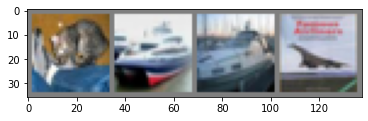

In [16]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%4s" % classes[labels[j]] for j in range(4)))

outputs = cifar10_predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print("Predicted: ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))

## Cleanup

In [18]:
cifar10_predictor.delete_endpoint()

## REFERENCES

1. GitHub Repository: <https://github.com/aws/amazon-sagemaker-examples/tree/master/sagemaker-python-sdk/pytorch_cnn_cifar10>
2. Notebook Link: <https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/pytorch_cnn_cifar10/pytorch_local_mode_cifar10.ipynb>
